In [19]:
#  Import relevant libraries

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

In [20]:
#  Check collected data

# Access raw data
file_path = os.path.expanduser('../resources/PLSTATS Desktop AXL Playwith.csv')

# Read the CSV file
data = pd.read_csv(file_path)

# Display the first few rows to verify it's loaded correctly
display(data.head())

print("Original data types:")
print(data.dtypes)

,Season End,Team,Avg Distance to Away Games,Squad Value,Net Summer Transfer Spend,Retained Manager,Avg Attendance,Wage Bill x1000,Retained Captain,Previous Season Disciplinary Points,Net Number of Transfers,Previous Season G/D,Previous Season Position,Position Bin
0,2019,Arsenal,371,580750000,71050000,0,59989,135360000,0,67,0,23,6,2
1,2020,Arsenal,163,604250000,107150000,1,60279,118540000,0,79,-3,22,5,1
2,2021,Arsenal,173,540800000,57140000,1,10000,147450000,1,108,5,8,8,1
3,2022,Arsenal,162,521000000,116250000,1,59763,114370000,0,68,4,16,8,2
4,2023,Arsenal,153,935000000,144080000,1,60186,101660000,0,72,1,13,5,2


Original data types:
Season End                              int64
Team                                   object
Avg Distance to Away Games              int64
Squad Value                             int64
Net Summer Transfer Spend               int64
Retained Manager                        int64
Avg Attendance                          int64
Wage Bill x1000                         int64
Retained Captain                        int64
Previous Season Disciplinary Points     int64
Net Number of Transfers                 int64
Previous Season G/D                     int64
Previous Season Position                int64
Position Bin                            int64
dtype: object


In [21]:
#  Preprocessing

# Function to identify problematic columns
def identify_mixed_type_columns(df):
    mixed_type_columns = []
    for column in df.columns:
        if df[column].dtype == 'object':
            try:
                pd.to_numeric(df[column])
            except ValueError:
                if df[column].str.contains(',').any():  # Check if any cell contains a comma
                    mixed_type_columns.append(column)
    return mixed_type_columns

# Identify problematic columns
problematic_columns = identify_mixed_type_columns(data)
print("Problematic columns:", problematic_columns)

# Handle problematic columns
for column in problematic_columns:
    data[column] = data[column].str.replace(',', '')  # Remove commas
    data[column] = pd.to_numeric(data[column], errors='coerce')  # Convert to numeric, invalid parsing will be set as NaN

# Identify numeric and categorical columns
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Remove 'Position Bin' from features if it's present
if 'Position Bin' in numeric_features:
    numeric_features.remove('Position Bin')
if 'Position Bin' in categorical_features:
    categorical_features.remove('Position Bin')

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Problematic columns: []
Numeric features: ['Season End', 'Avg Distance to Away Games', 'Squad Value', 'Net Summer Transfer Spend', 'Retained Manager', 'Avg Attendance', 'Wage Bill x1000', 'Retained Captain', 'Previous Season Disciplinary Points', 'Net Number of Transfers', 'Previous Season G/D', 'Previous Season Position', 'Position Bin']
Categorical features: ['Team']


In [22]:
# Prepare the features and target

X = data.drop('Position Bin', axis=1)
y = data['Position Bin']

In [23]:
# Encode target variable

le = LabelEncoder()
y = le.fit_transform(y)

In [24]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Fit the preprocessor on the training data and transform both training and test data

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

c:\Users\Jamie\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Jamie\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [26]:
# Get feature names after preprocessing

onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + cat_feature_names

In [27]:
# Convert to DataFrames

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

In [28]:
print("Preprocessing complete. Ready for model training.")
print(f"Training set shape: {X_train_preprocessed.shape}")
print(f"Testing set shape: {X_test_preprocessed.shape}")

Preprocessing complete. Ready for model training.
Training set shape: (96, 37)
Testing set shape: (24, 37)


In [29]:
# Display sample of preprocessed features to verify

display("\nSample of preprocessed features (training set):")
display(X_train_preprocessed.head())

'\nSample of preprocessed features (training set):'

,Season End,Avg Distance to Away Games,Squad Value,Net Summer Transfer Spend,Retained Manager,Avg Attendance,Wage Bill x1000,Retained Captain,Previous Season Disciplinary Points,Net Number of Transfers,...,Team_Manchester City,Team_Manchester United,Team_Newcastle,Team_Norwich City,Team_Sheffield United,Team_Southampton,Team_Tottenham,Team_Watford,Team_West Ham,Team_Wolverhampton
0,-1.485985,0.184280,-0.014788,0.016174,0.56131,0.278806,0.022644,0.690596,-0.788917,-0.078975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.894057,0.619812,-0.602514,-0.417240,0.56131,-1.145939,-0.835025,0.690596,-0.458769,0.580297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.289798,-0.520867,-0.742166,-0.330148,0.56131,-0.826905,-1.254789,-1.448024,-0.854947,0.909933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.485985,-0.769742,-0.602443,0.212600,0.56131,-0.121273,-0.937157,-1.448024,0.729766,1.239569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.302130,-0.749002,1.031982,-0.121792,0.56131,-1.171406,2.153176,0.690596,0.003439,1.239569,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Print feature names after preprocessing

print("\nFeature names after preprocessing:")
print(X_train_preprocessed.columns.tolist())


Feature names after preprocessing:
['Season End', 'Avg Distance to Away Games', 'Squad Value', 'Net Summer Transfer Spend', 'Retained Manager', 'Avg Attendance', 'Wage Bill x1000', 'Retained Captain', 'Previous Season Disciplinary Points', 'Net Number of Transfers', 'Previous Season G/D', 'Previous Season Position', 'Team_Aston Villa', 'Team_Bournemouth', 'Team_Brentford', 'Team_Brighton', 'Team_Burnley', 'Team_Cardiff', 'Team_Chelsea', 'Team_Crystal Palace', 'Team_Everton', 'Team_Fulham', 'Team_Huddersfield', 'Team_Leeds', 'Team_Leicester', 'Team_Liverpool', 'Team_Luton', 'Team_Manchester City', 'Team_Manchester United', 'Team_Newcastle', 'Team_Norwich City', 'Team_Sheffield United', 'Team_Southampton', 'Team_Tottenham', 'Team_Watford', 'Team_West Ham', 'Team_Wolverhampton']


In [31]:
# Train a RandomForest model

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Make predictions

y_pred = rf.predict(X_test_preprocessed)

In [33]:
# Evaluate the model

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.56      1.00      0.71         5
           2       1.00      1.00      1.00         9

    accuracy                           0.83        24
   macro avg       0.85      0.87      0.82        24
weighted avg       0.91      0.83      0.84        24


Confusion Matrix:
[[6 4 0]
 [0 5 0]
 [0 0 9]]


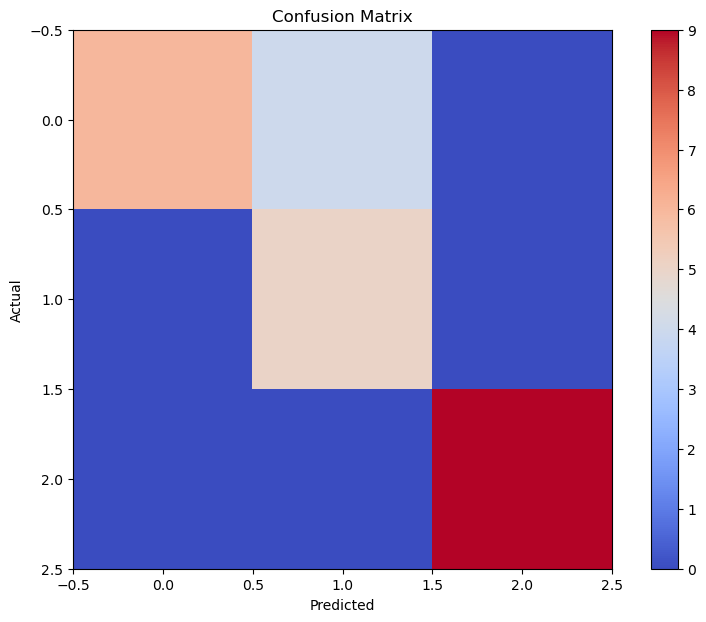

In [34]:
# Visualize the confusion matrix

plt.figure(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
#use joblib to save model

joblib.dump(rf, '../app/model.joblib')

['../app/model.joblib']